# NLP Analysis of WiMLDS Event Titles

### Date Started
19-May-2019

### Date Updated
18-Jun-2019

### Reference 1:  Topic Modeling with Gensim (Python)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### Reference 2:  Topic modeling visualization – How to present the results of LDA models?  
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
>In this post, we discuss techniques to visualize the output and results from topic model (LDA) based on the gensim package.

## Import Packages
The core packages used in this tutorial are `re`, `gensim`, `spacy` and `pyLDAvis`. Besides this we will also using `matplotlib`, `numpy` and `pandas` for data handling and visualization. Let’s import them.

In [1]:
#!pip install pyLDAvis

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
    
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# sys
import sys

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
import matplotlib 
print("Python Version:", sys.version)
print(matplotlib.__version__)
print(pd.__version__)

Python Version: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
2.2.2
0.23.0


## Read in data

In [5]:
df_events = pd.read_csv('wimlds_events_2019_05_08.csv')

In [6]:
len(df_events)

439

In [7]:
list(df_events)

['chapter_name', 'link', 'local_date', 'name', 'yes_rsvp_count']

In [8]:
len(df_events.chapter_name.unique())

43

In [9]:
df_events.local_date.min()

'1/10/19'

In [10]:
df_events.local_date.max()

'9/8/18'

In [11]:
df_events['event_date'] =  pd.to_datetime(df_events['local_date'], format='%x')

In [12]:
df_events.event_date.min()

Timestamp('2014-01-23 00:00:00')

In [13]:
df_events.event_date.max()

Timestamp('2019-05-07 00:00:00')

In [14]:
df_events.head(10)

,chapter_name,link,local_date,name,yes_rsvp_count,event_date
0,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,3/10/18,Big Data: From Chaos to Intelligence,17,2018-03-10
1,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,5/5/18,Machine Learning: A Focus on Supervised and Un...,35,2018-05-05
2,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,7/21/18,Deep Learning: Build An Image Classification M...,20,2018-07-21
3,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,6/24/17,NLP: Zero to one,59,2017-06-24
4,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,8/5/17,Handling Imbalanced Datasets: Building a model...,63,2017-08-05
5,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,11/25/17,The ABC-XYZ of Data Science before Machine Lea...,50,2017-11-25
6,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,12/8/16,Uncovering patterns and trends using explorato...,17,2016-12-08
7,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,1/28/17,Extracting Your Own Web Data using Scraping Tools,8,2017-01-28
8,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,2/25/17,TensorFlow Post-Summit Event,95,2017-02-25
9,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,3/25/17,Fueling the Artificial Intelligence revolution...,35,2017-03-25


In [15]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [16]:
# Convert to list
data = df_events.name.values.tolist()

In [17]:
data

['Big Data: From Chaos to Intelligence',
 'Machine Learning: A Focus on Supervised and Unsupervised Learning',
 'Deep Learning: Build An Image Classification Model',
 'NLP: Zero to one',
 'Handling Imbalanced Datasets: Building a model and deploying to production',
 'The ABC-XYZ of Data Science before Machine Learning',
 'Uncovering patterns and trends using exploratory data analysis',
 'Extracting Your Own Web Data using Scraping Tools',
 'TensorFlow Post-Summit Event',
 'Fueling the Artificial Intelligence revolution with gaming!',
 'Sentiment Analysis in R',
 'Unravelling Intel Deep Learning SDK',
 'TensorFlow : Zero to One',
 'Treasure Island: Bioinformatics for everyone.',
 'Deep Learning for Crypt-analysis using TensorFlow',
 'Prototyping Back Propagation in Excel For Greater Good',
 'Data Science and Machine Learning in Practice',
 '#NairobiWiMLDS turns 1 + Christmas Party',
 'Around the world of data science in 60 minutes or less',
 'TensorFlow Series: Convolutional Neural Netw

In [18]:
len(data)

439

---

# Topic modeling visualization – How to present the results of LDA models?

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

Updated:  29-May-2019


## 1. Introduction
In topic modeling with gensim, we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.

In this post, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

I will be using a portion of the 20 Newsgroups dataset since the focus is more on approaches to visualizing the results.

Let’s begin by importing the packages and the 20 News Groups dataset.

## Read in data

In [19]:
df_events = pd.read_csv('wimlds_events_2019_05_08.csv')
len(df_events)
df_events['event_date'] =  pd.to_datetime(df_events['local_date'], format='%x')

In [20]:
df_events.head(10)

,chapter_name,link,local_date,name,yes_rsvp_count,event_date
0,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,3/10/18,Big Data: From Chaos to Intelligence,17,2018-03-10
1,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,5/5/18,Machine Learning: A Focus on Supervised and Un...,35,2018-05-05
2,Abuja Women in Machine Learning and Data Science,https://www.meetup.com/Abuja-Women-in-Machine-...,7/21/18,Deep Learning: Build An Image Classification M...,20,2018-07-21
3,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,6/24/17,NLP: Zero to one,59,2017-06-24
4,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,8/5/17,Handling Imbalanced Datasets: Building a model...,63,2017-08-05
5,Lagos Women in Machine Learning & Data Science,https://www.meetup.com/Lagos-Women-in-Machine-...,11/25/17,The ABC-XYZ of Data Science before Machine Lea...,50,2017-11-25
6,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,12/8/16,Uncovering patterns and trends using explorato...,17,2016-12-08
7,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,1/28/17,Extracting Your Own Web Data using Scraping Tools,8,2017-01-28
8,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,2/25/17,TensorFlow Post-Summit Event,95,2017-02-25
9,Nairobi Women in Machine Learning & Data Science,https://www.meetup.com/Nairobi-Women-in-Machin...,3/25/17,Fueling the Artificial Intelligence revolution...,35,2017-03-25


## 2. Set Dataset
 

In [21]:
# Import Dataset
df = df_events.copy()
print(df.shape)  #> (2361, 3)
df = df.drop(["local_date", "yes_rsvp_count", "link"], axis=1)
df.head()

(439, 6)


,chapter_name,name,event_date
0,Abuja Women in Machine Learning and Data Science,Big Data: From Chaos to Intelligence,2018-03-10
1,Abuja Women in Machine Learning and Data Science,Machine Learning: A Focus on Supervised and Un...,2018-05-05
2,Abuja Women in Machine Learning and Data Science,Deep Learning: Build An Image Classification M...,2018-07-21
3,Lagos Women in Machine Learning & Data Science,NLP: Zero to one,2017-06-24
4,Lagos Women in Machine Learning & Data Science,Handling Imbalanced Datasets: Building a model...,2017-08-05


## 3. Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [22]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.name.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', \
#'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]


[['big', 'data', 'from', 'chaos', 'to', 'intelligence']]


In [23]:
len(data)

439

## 4. Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [ ]:
# change threshold below from 100 to 15

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=3) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=3)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## 5. Build the Topic Model
To build the LDA topic model using LdaModel(), you need the corpus and the dictionary. Let’s create them first and then build the model. The trained topics (keywords and weights) are printed below as well.

*Example:*  If you examine the topic key words, they are nicely segregate and collectively represent the topics we initially chose: Christianity, Hockey, MidEast and Motorcycles. Nice!

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.136*"ai" + 0.078*"share" + 0.056*"code" + 0.037*"pdx" + 0.037*"tell" + '
  '0.025*"geospatial" + 0.024*"center" + 0.020*"coffee" + 0.018*"robotic" + '
  '0.017*"hand"'),
 (1,
  '0.065*"intro" + 0.059*"event" + 0.048*"social" + 0.028*"tensorflow" + '
  '0.025*"detection" + 0.023*"deep_learn" + 0.022*"traffic" + 0.022*"onsite" + '
  '0.022*"light" + 0.022*"health_care"'),
 (2,
  '0.196*"data_science" + 0.132*"machine_learn" + 0.076*"meetup" + '
  '0.073*"python" + 0.026*"herramienta" + 0.026*"session" + 0.021*"art" + '
  '0.019*"get" + 0.015*"spotify" + 0.012*"casual"'),
 (3,
  '0.201*"woman" + 0.052*"conference" + 0.031*"kick" + 0.031*"meeting" + '
  '0.031*"organiser" + 0.027*"wids_conference" + 0.024*"fireside_chat" + '
  '0.018*"halifax" + 0.018*"evening" + 0.017*"burlington"'),
 (4,
  '0.045*"learn" + 0.038*"party" + 0.027*"lunch" + 0.027*"technology" + '
  '0.026*"transfer" + 0.026*"future" + 0.022*"winter" + 0.020*"con" + '
  '0.019*"visualization" + 0.017*"good"'),
 (5,

## 6. What is the Dominant topic and its percentage contribution in each document
In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
print(len(df_topic_sents_keywords))
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
len(df_dominant_topic)


439


439

In [27]:
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.7750,"wimld, kickoff, meet_greet, manila, meeting, c...","[big_data, chaos, intelligence]"
1,1,8.0,0.6548,"lady, world, digital, idea, lecture, data, alg...","[machine_learn, focus, supervise, unsupervised..."
2,2,1.0,0.8500,"intro, event, social, tensorflow, detection, d...","[deep_learn, build, image, classification, model]"
3,3,1.0,0.5500,"intro, event, social, tensorflow, detection, d...",[nlp]
4,4,1.0,0.8875,"intro, event, social, tensorflow, detection, d...","[handle, imbalanced, dataset, building, model,..."
5,5,2.0,0.7000,"data_science, machine_learn, meetup, python, h...","[data_science, machine_learn]"
6,6,6.0,0.6998,"datum, fast, practical, portland, school, code...","[uncover, pattern, trend, exploratory, datum, ..."
7,7,6.0,0.8500,"datum, fast, practical, portland, school, code...","[extract, web, datum, scraping, tool]"
8,8,1.0,0.8200,"intro, event, social, tensorflow, detection, d...","[tensorflow, post, summit, event]"
9,9,4.0,0.7750,"learn, party, lunch, technology, transfer, fut...","[fuel, revolution, gaming]"


## 7. The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(25)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8500,"ai, share, code, pdx, tell, geospatial, center, coffee, robotic, hand","[ai, edge, iotiot, coep, bhau]"
1,1.0,0.8875,"intro, event, social, tensorflow, detection, deep_learn, traffic, onsite, light, health_care","[handle, imbalanced, dataset, building, model, deploy, production]"
2,2.0,0.8500,"data_science, machine_learn, meetup, python, herramienta, session, art, get, spotify, casual","[boulder, startup, week, data_science, track]"
3,3.0,0.7750,"woman, conference, kick, meeting, organiser, wids_conference, fireside_chat, halifax, evening, b...","[kick, organiser, meeting]"
4,4.0,0.8875,"learn, party, lunch, technology, transfer, future, winter, con, visualization, good","[healthy, wealthy, wise, decision, modeling, personalize, policy]"
5,5.0,0.8714,"workshop, talk, tech, day, deep_learning, introduction, community, diversity, night, trip","[road, trip, processing, community, day, boston]"
6,6.0,0.9000,"datum, fast, practical, portland, school, coder, analytic, afternoon, method, thick","[scale, language, understanding, mono, lingual, multi, lingual, context]"
7,7.0,0.9000,"lightning_talk, artificial, work, happy_hour, first, inteligencia, haciendo, carrera, fire, design","[lisa, soro, create, creativity, artificial, life, evolution, design]"
8,8.0,0.8875,"lady, world, digital, idea, lecture, data, algorithmic, ethic, fairness, bias","[markdown, czyli, wizualizacja, danych, ºnych, formatach, html]"
9,9.0,0.8714,"wimld, kickoff, meet_greet, manila, meeting, cfp, proposal, graph, big_data, edmonton","[pygotham, proposal, cfp, brainstorm, rsvp, pyladie]"


## 8. Frequency Distribution of Word Counts in Documents
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

In [29]:
# # original code
# doc_lens = [len(d) for d in df_dominant_topic.Text]

# # Plot
# plt.figure(figsize=(16,7), dpi=160)
# plt.hist(doc_lens, bins = 1000, color='navy')
# plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
# plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
# plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
# #plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
# #plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

# plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
# plt.tick_params(size=16)
# plt.xticks(np.linspace(0,1000,9))
# plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
# plt.show()

In [30]:
# changes made in below
# figsize
# xlim from 1000 to 500 (docs)
# xticks from 1000 to 500
# plt.text(750, 100, ---> 500, 100

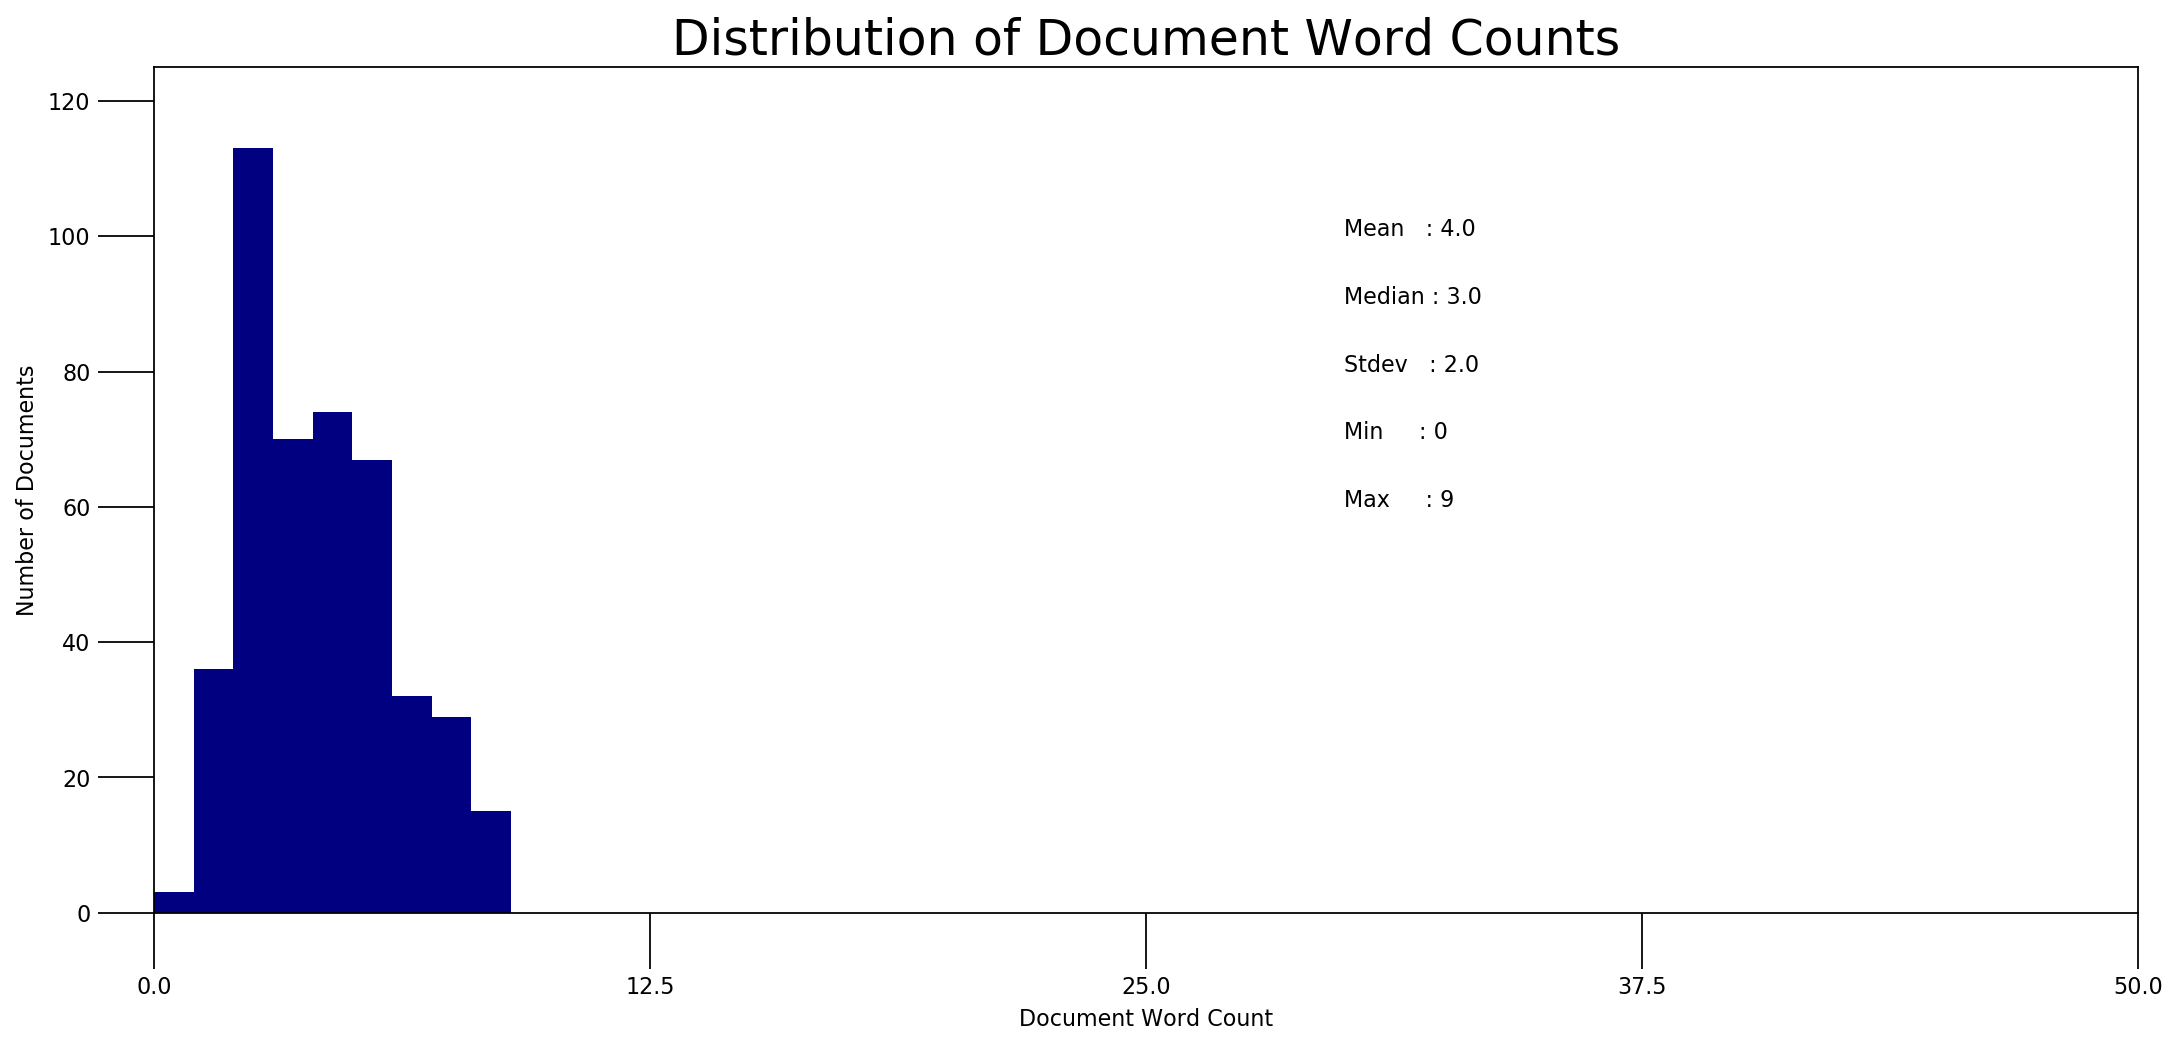

In [31]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 9, color='navy')
plt.text(30, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(30, 90, "Median : " + str(round(np.median(doc_lens))))
plt.text(30,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(30, 70,  "Min     : " + str(round(np.min(doc_lens))))
plt.text(30, 60,  "Max     : " + str(round(np.max(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 25), ylim=(0, 125), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=25)
plt.xticks(np.linspace(0,50,5))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

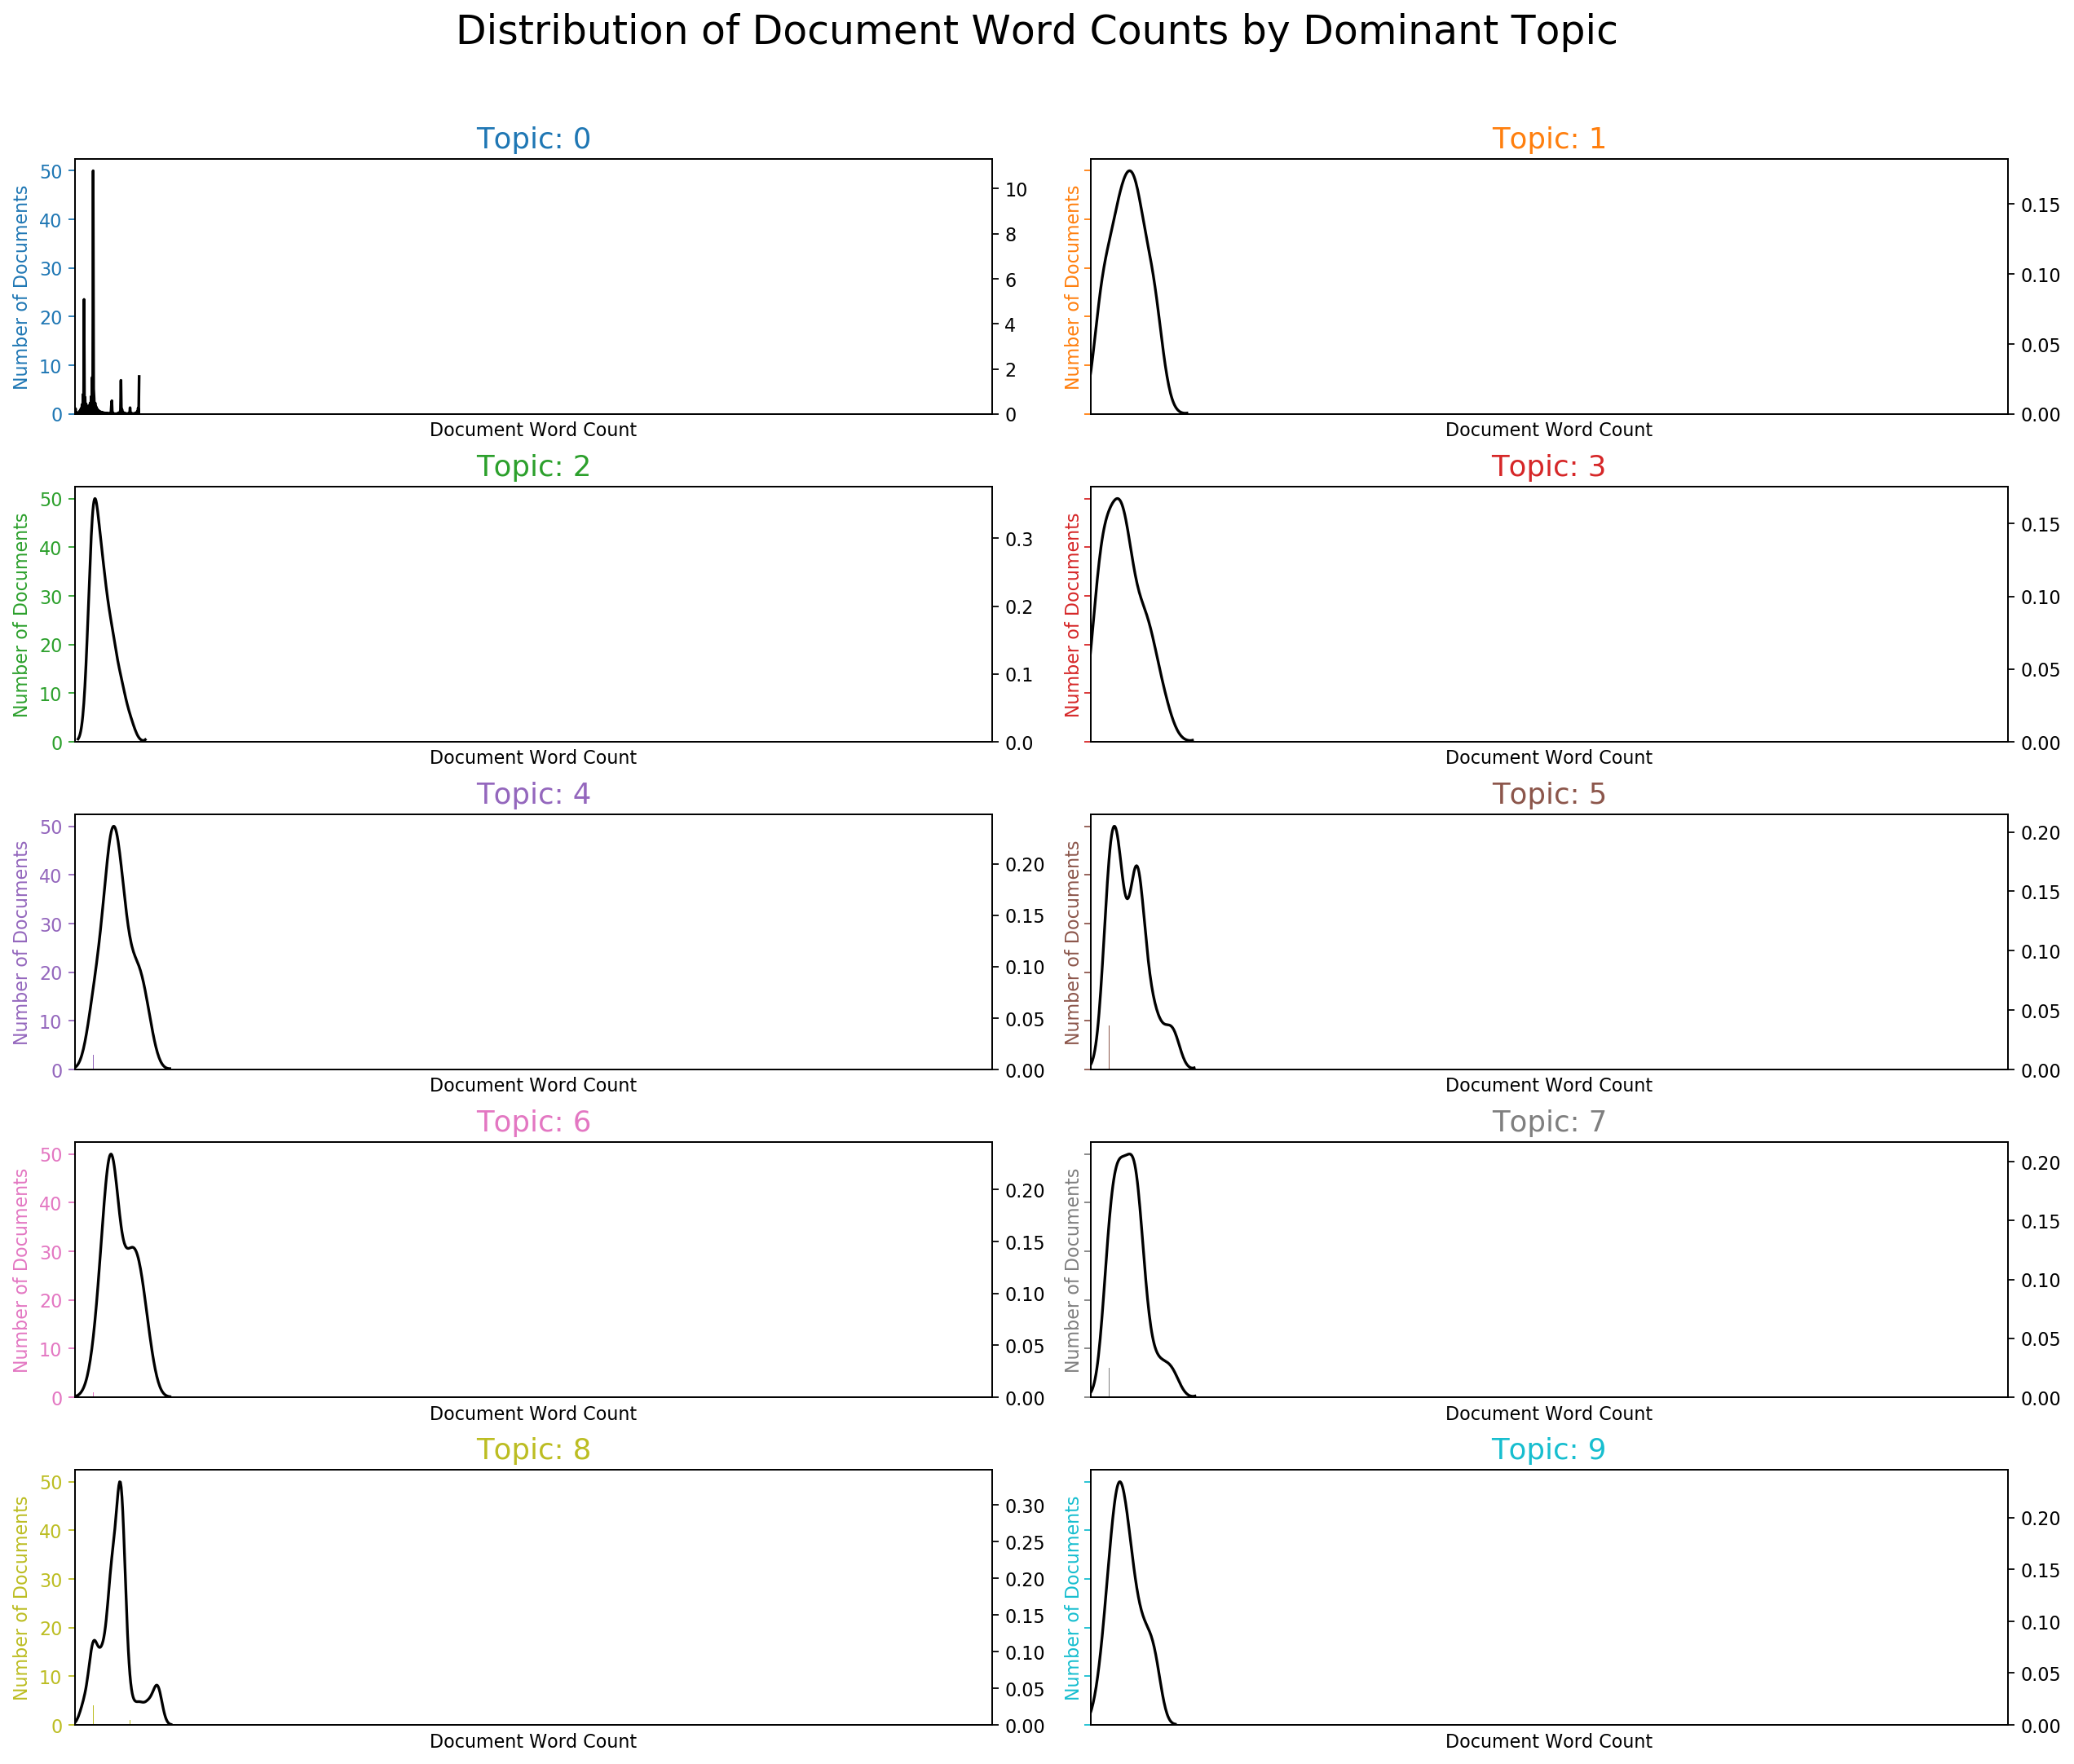

In [36]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 800, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,10,0.5))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## 9. Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

In [37]:
mcolors.CSS4_COLORS.items()

dict_items([('aliceblue', '#F0F8FF'), ('antiquewhite', '#FAEBD7'), ('aqua', '#00FFFF'), ('aquamarine', '#7FFFD4'), ('azure', '#F0FFFF'), ('beige', '#F5F5DC'), ('bisque', '#FFE4C4'), ('black', '#000000'), ('blanchedalmond', '#FFEBCD'), ('blue', '#0000FF'), ('blueviolet', '#8A2BE2'), ('brown', '#A52A2A'), ('burlywood', '#DEB887'), ('cadetblue', '#5F9EA0'), ('chartreuse', '#7FFF00'), ('chocolate', '#D2691E'), ('coral', '#FF7F50'), ('cornflowerblue', '#6495ED'), ('cornsilk', '#FFF8DC'), ('crimson', '#DC143C'), ('cyan', '#00FFFF'), ('darkblue', '#00008B'), ('darkcyan', '#008B8B'), ('darkgoldenrod', '#B8860B'), ('darkgray', '#A9A9A9'), ('darkgreen', '#006400'), ('darkgrey', '#A9A9A9'), ('darkkhaki', '#BDB76B'), ('darkmagenta', '#8B008B'), ('darkolivegreen', '#556B2F'), ('darkorange', '#FF8C00'), ('darkorchid', '#9932CC'), ('darkred', '#8B0000'), ('darksalmon', '#E9967A'), ('darkseagreen', '#8FBC8F'), ('darkslateblue', '#483D8B'), ('darkslategray', '#2F4F4F'), ('darkslategrey', '#2F4F4F'), ('

In [41]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
len(topics)

10

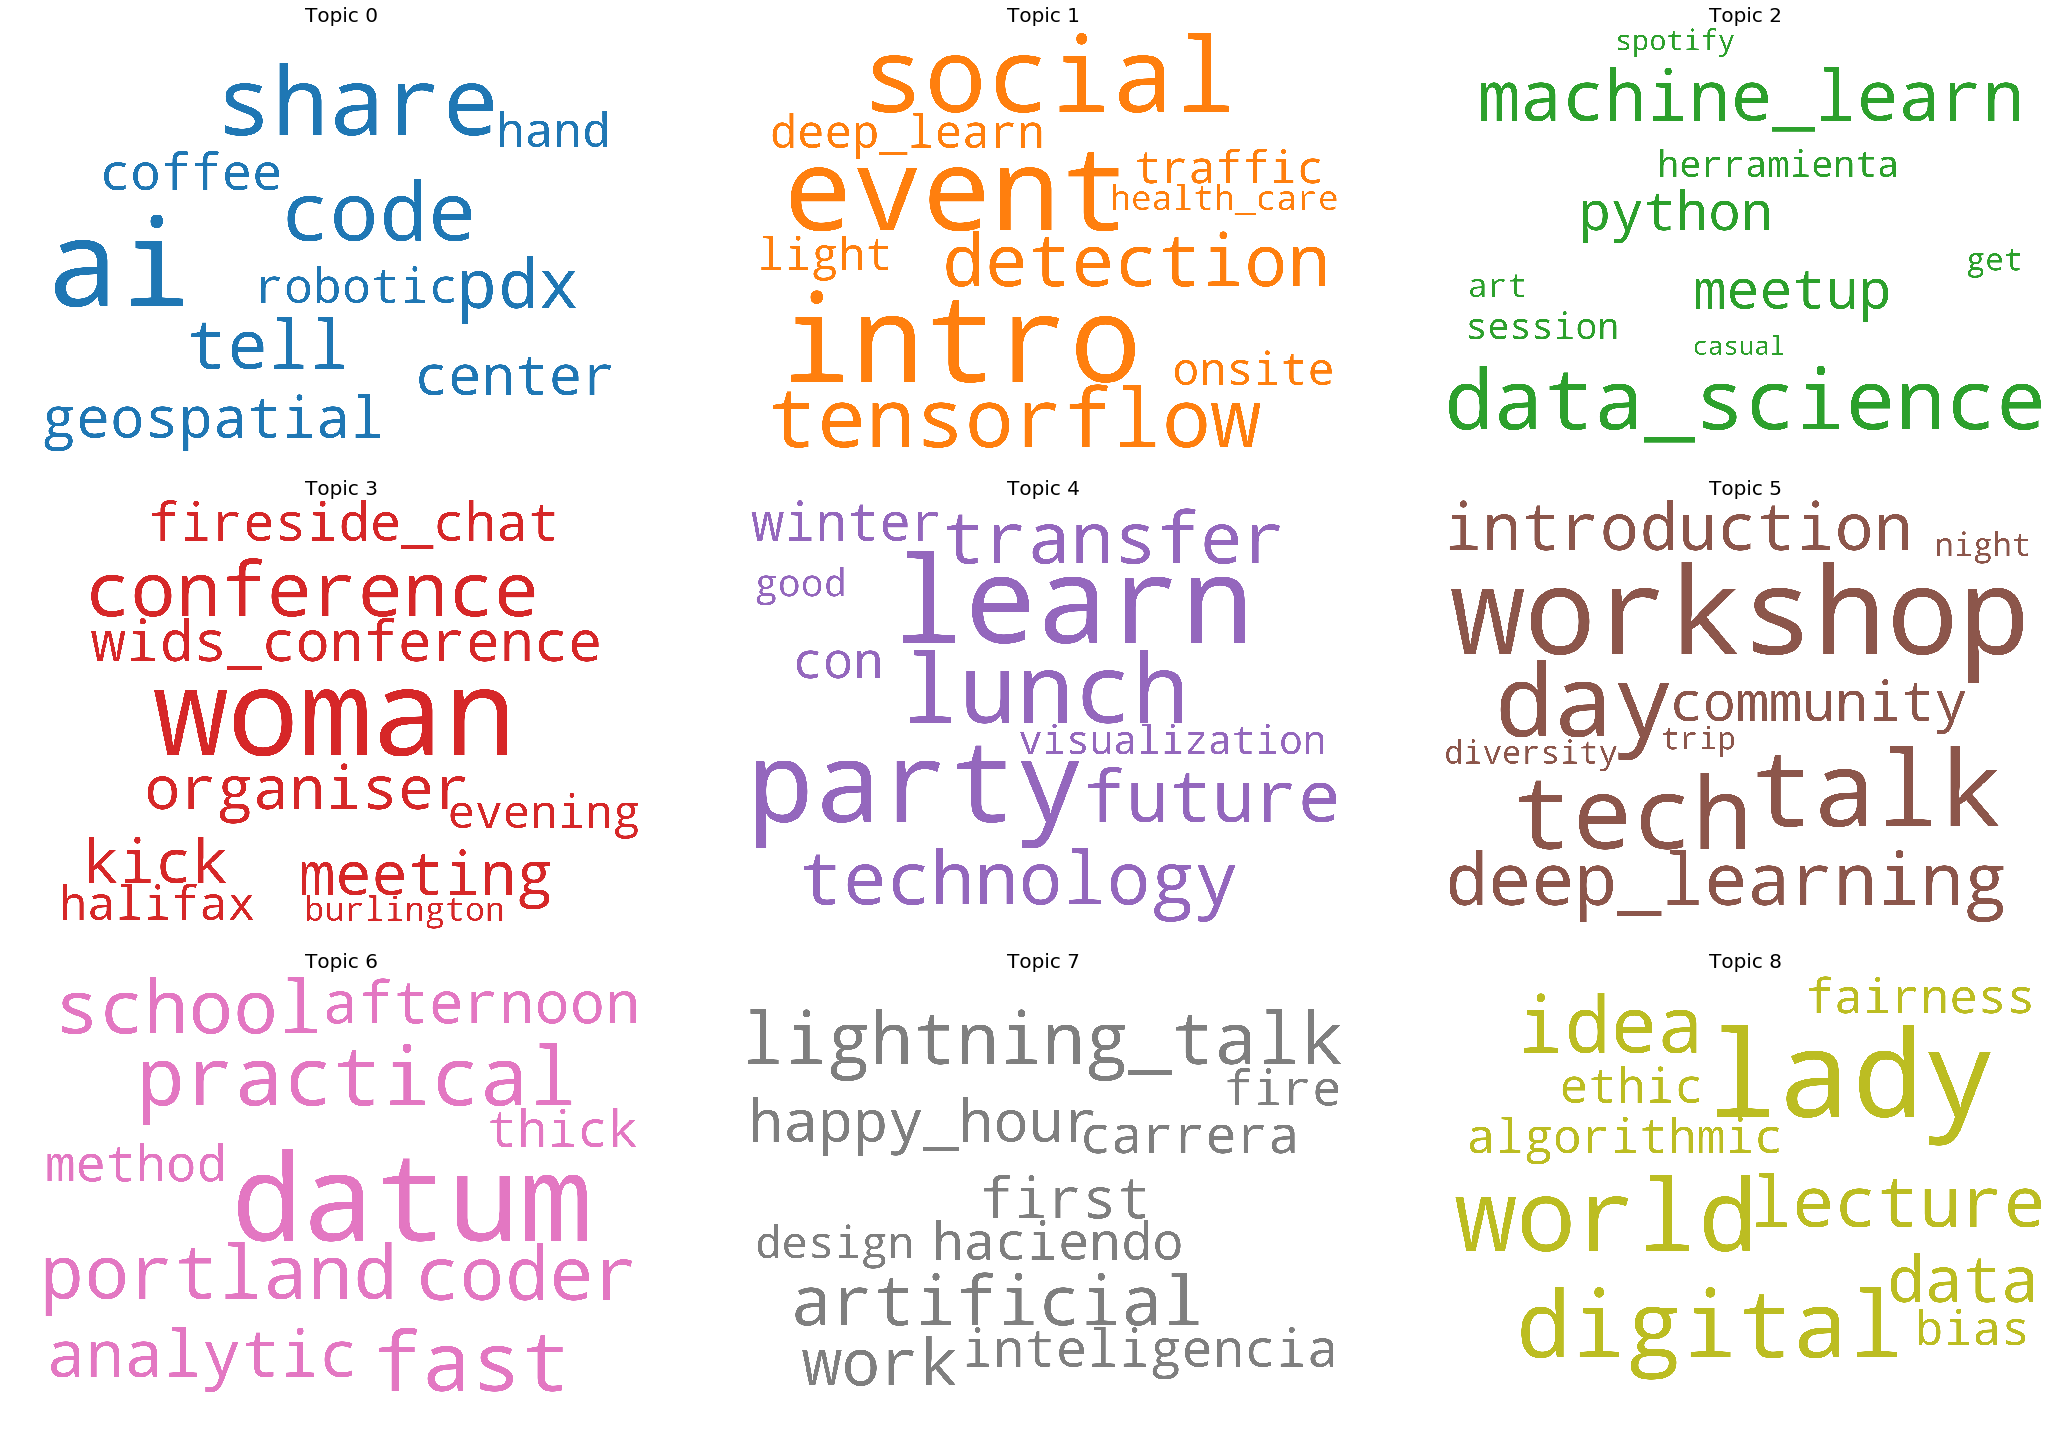

In [42]:
fig, axes = plt.subplots(3, 3, figsize=(30,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

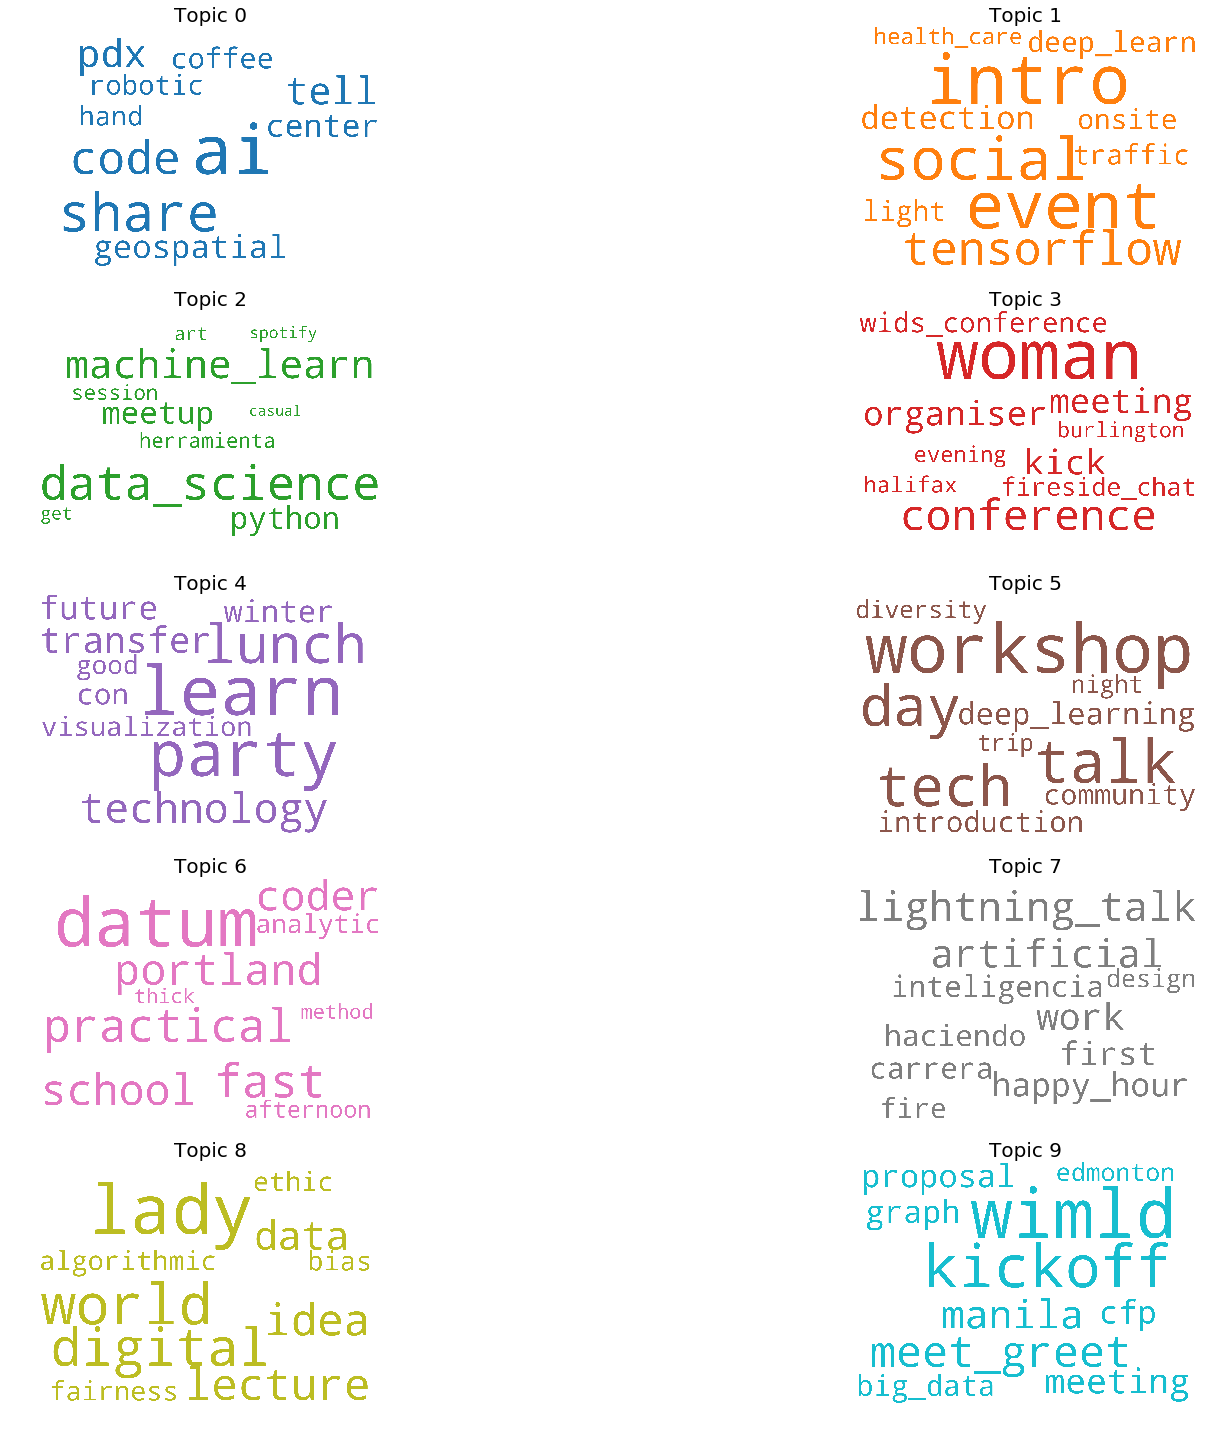

In [43]:
fig, axes = plt.subplots(5, 2, figsize=(30,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=20))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## 10. Word Counts of Topic Keywords
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.`

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

In [44]:
#axes.flatten()

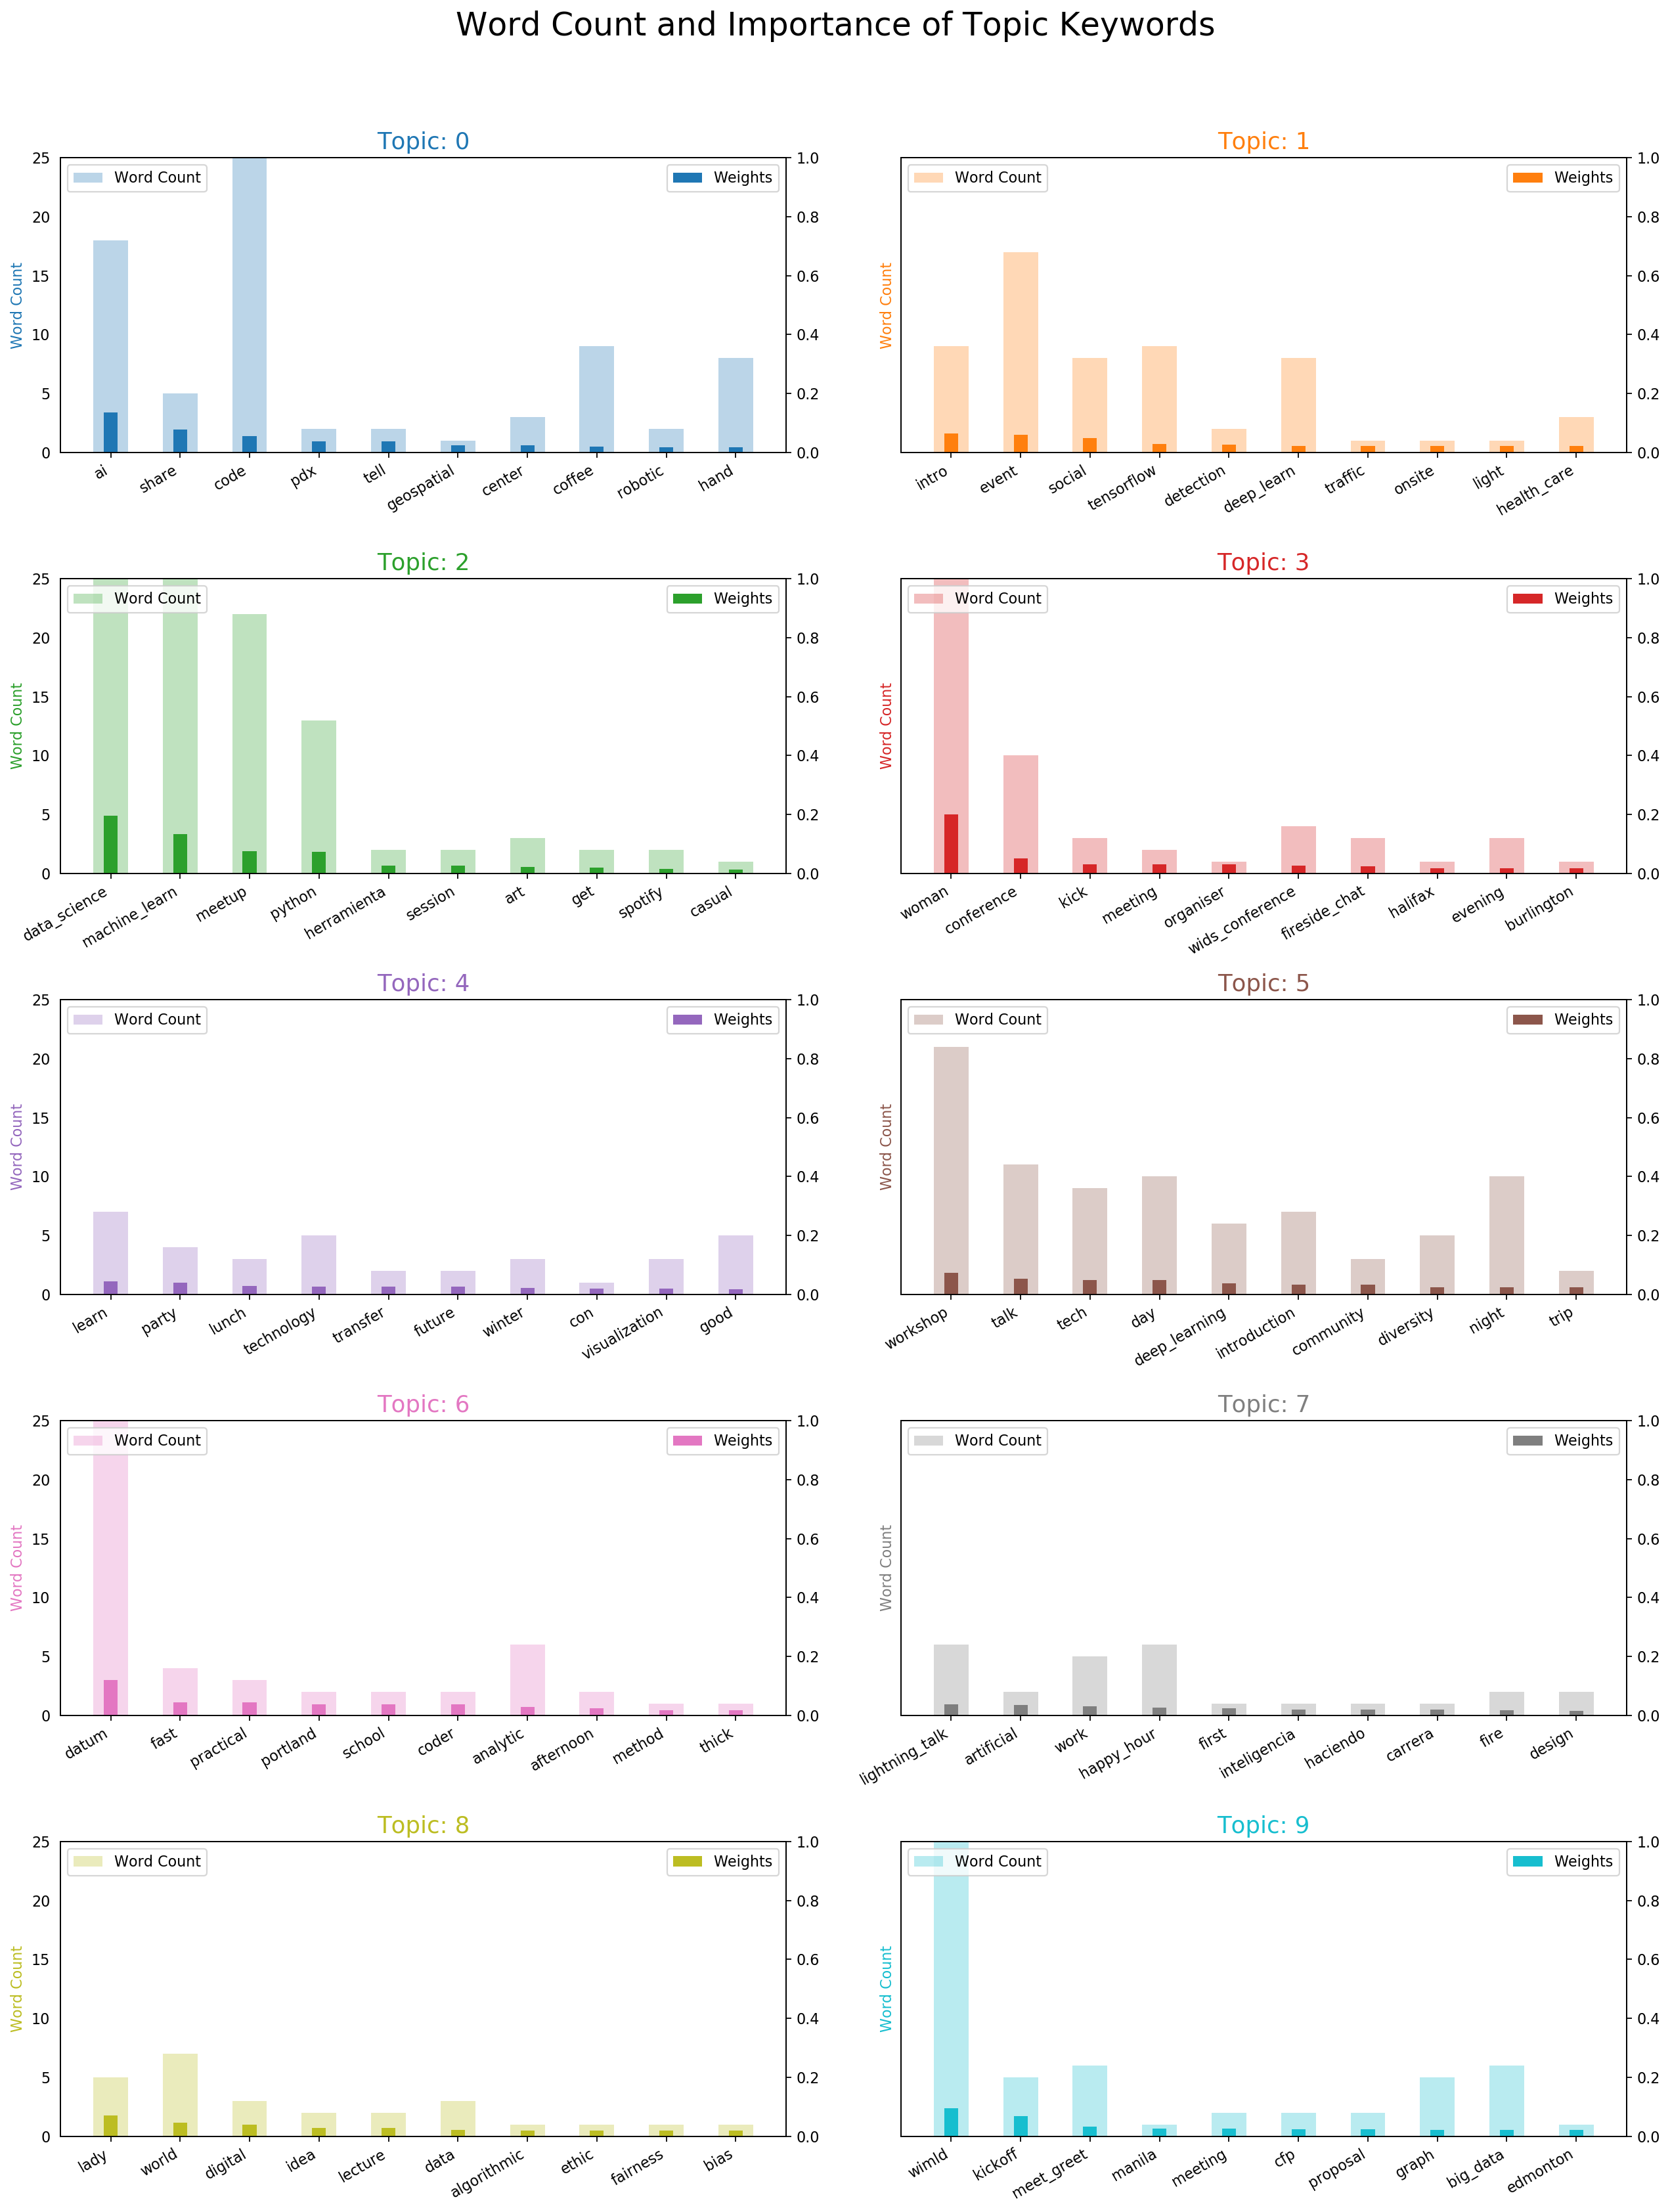

In [45]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 1); ax.set_ylim(0, 25)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## 11. Sentence Chart Colored by Topic
Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

[(0, [9]), (1, [9]), (2, [9])]
[(3, [8, 2]), (4, [8]), (5, [2]), (6, [8, 2]), (7, [8, 2])]
[(8, [1]), (9, [1]), (10, [1]), (11, [1]), (12, [1])]
[(13, [1])]
[(12, [1]), (14, [1]), (15, [1]), (16, [1]), (17, [1]), (18, [1]), (19, [1])]
[(5, [2]), (20, [2])]
[(21, [1]), (22, [6]), (23, [6, 1]), (24, [6, 1]), (25, [6]), (26, [6, 1])]
[(22, [6]), (27, [6]), (28, [6]), (29, [6]), (30, [6])]
[(31, [1]), (32, [1]), (33, [1]), (34, [1])]
[(35, [4]), (36, [4]), (37, [4])]
[(21, [1]), (38, [1])]
[(10, [1]), (39, [1]), (40, [1]), (41, [1])]


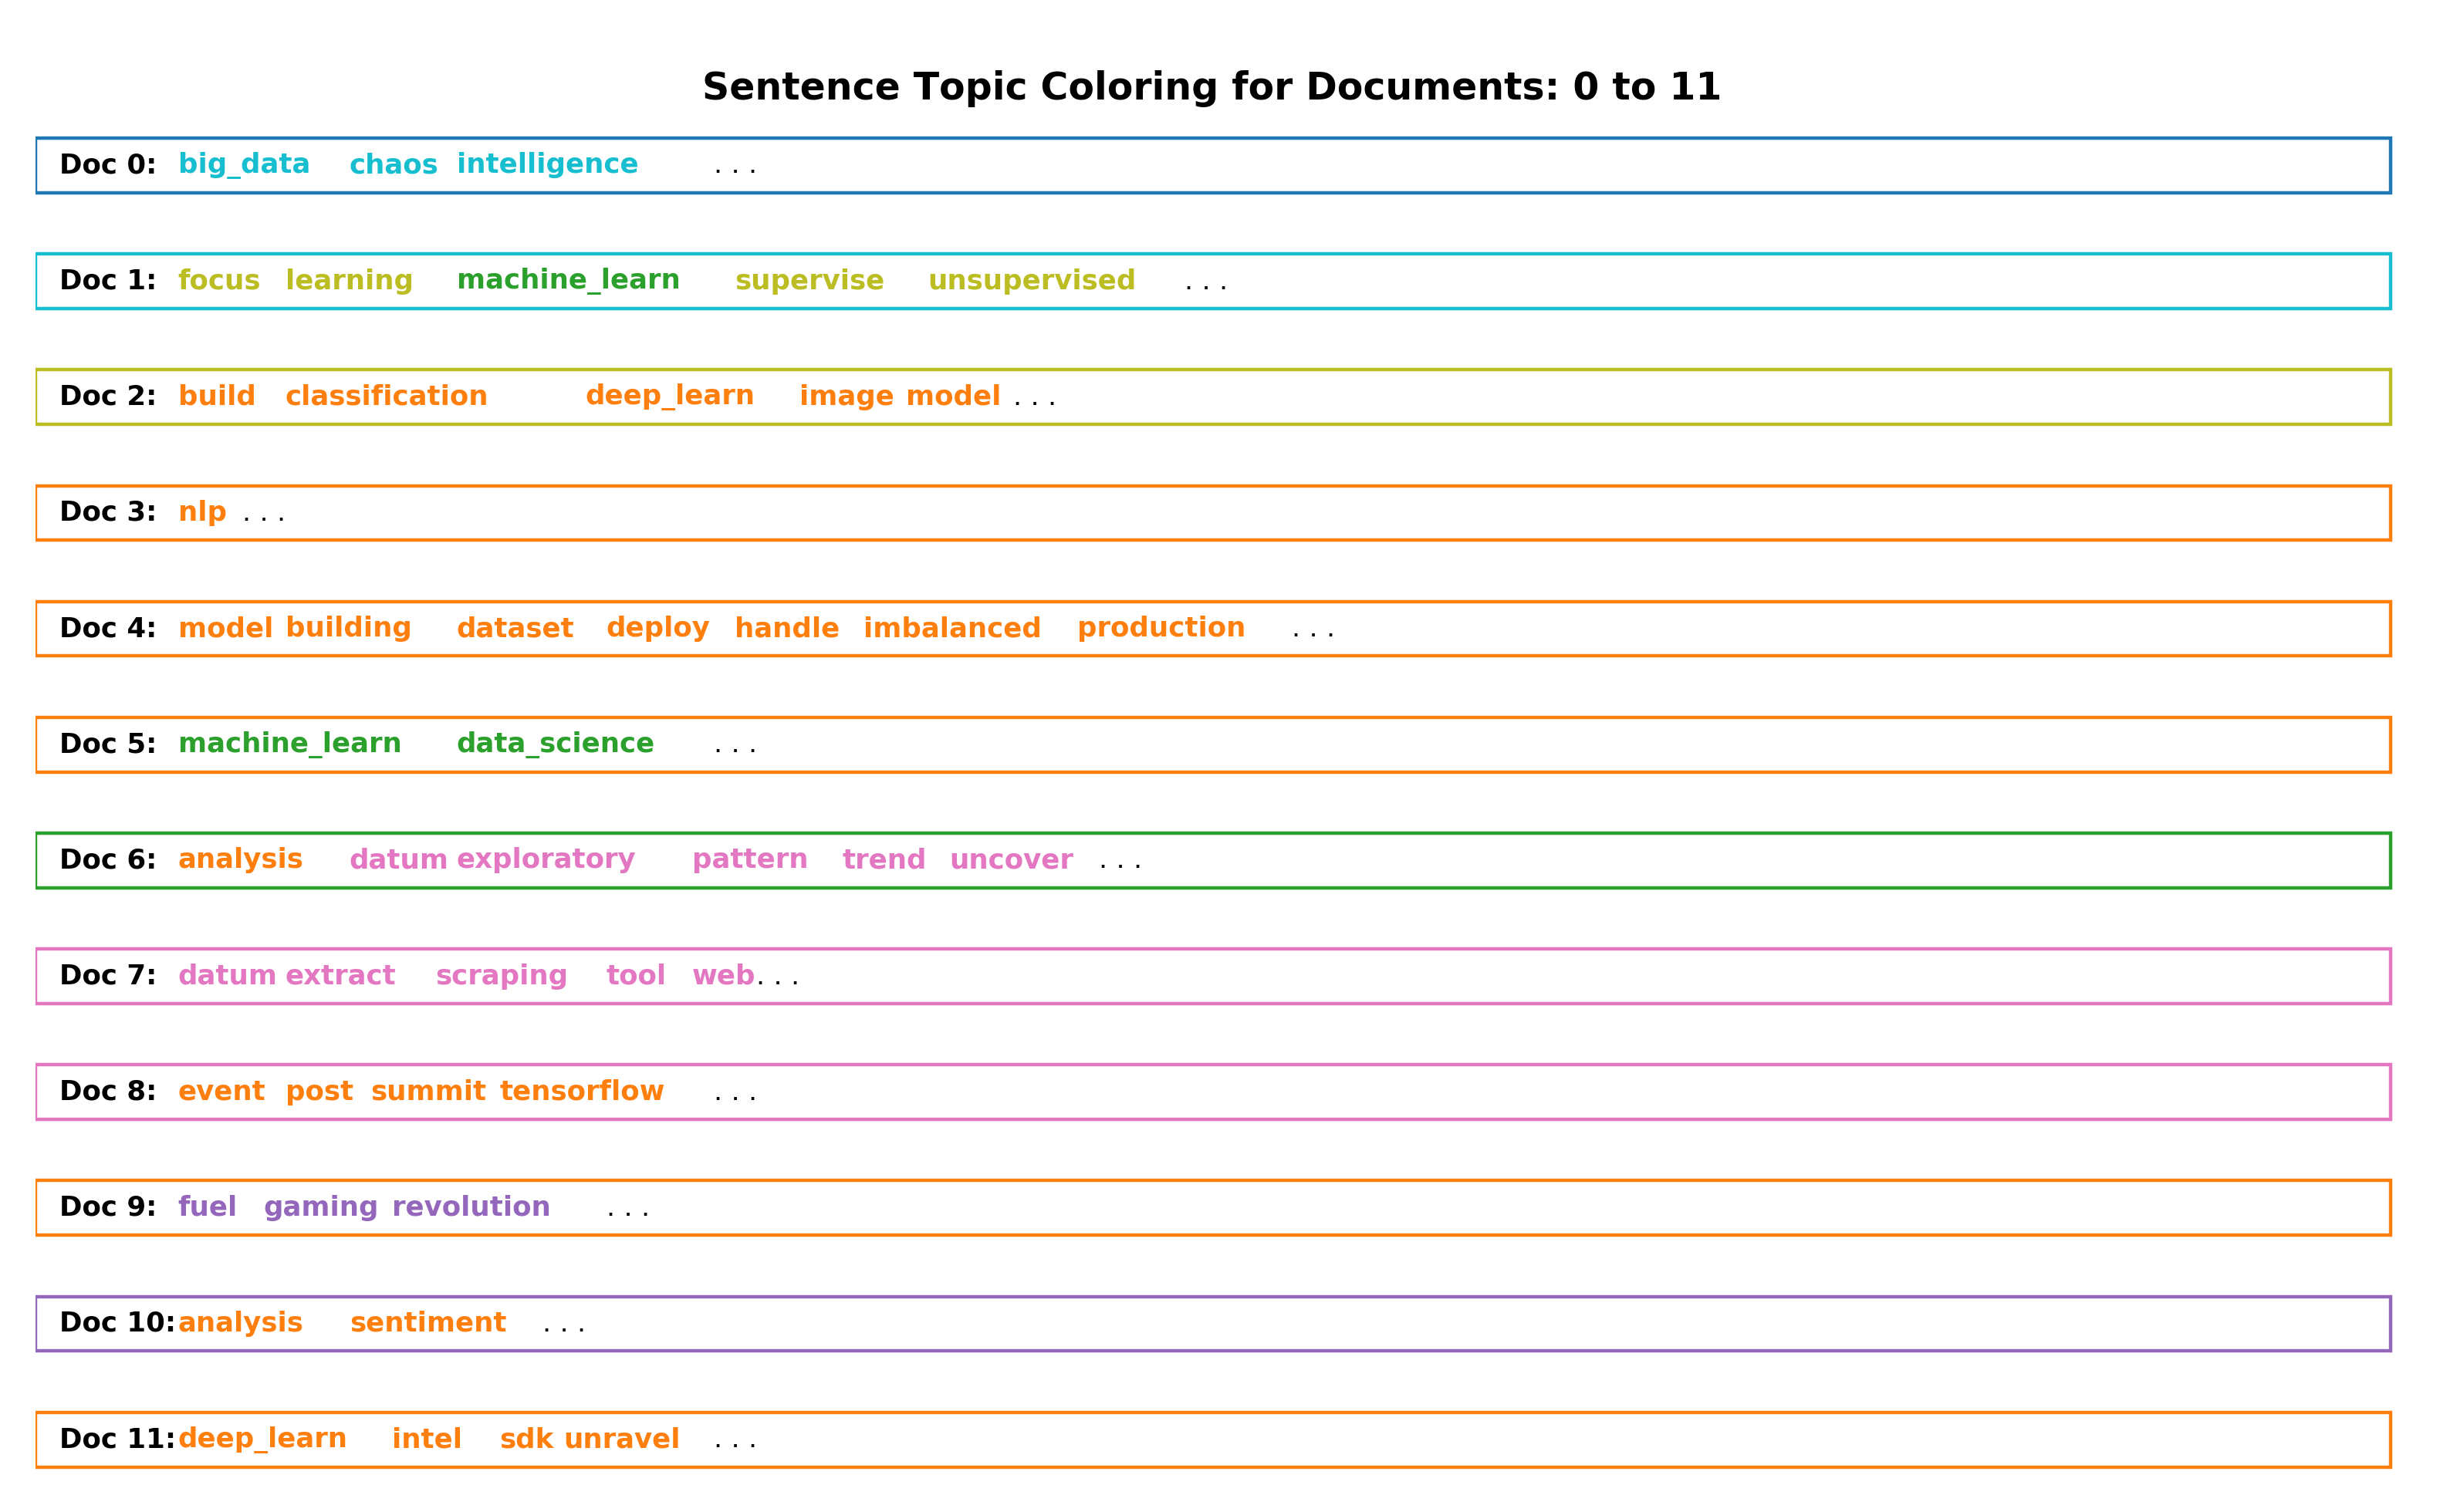

In [46]:
from IPython.core.debugger import set_trace


# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    #set_trace()

    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            print(wordid_topics)
            #return topic_percs, wordid_topics, wordid_phivalues
            word_dominanttopic = [(lda_model.id2word[wd], topic[0] if topic else "no topic") for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            color=mycolors[0]
            try:
                topic_idx = topic_percs_sorted[0][0]
                color = mycolors[topic_idx]
            except:
                pass
            
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1
                                   ,color=color
                                   , linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                color = mycolors[0]
                try:
                    color=mycolors[topics]
                except:
                    pass
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16
                            , color=color
                            ,transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## 12. What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [59]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 5]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

1. The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
2. The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

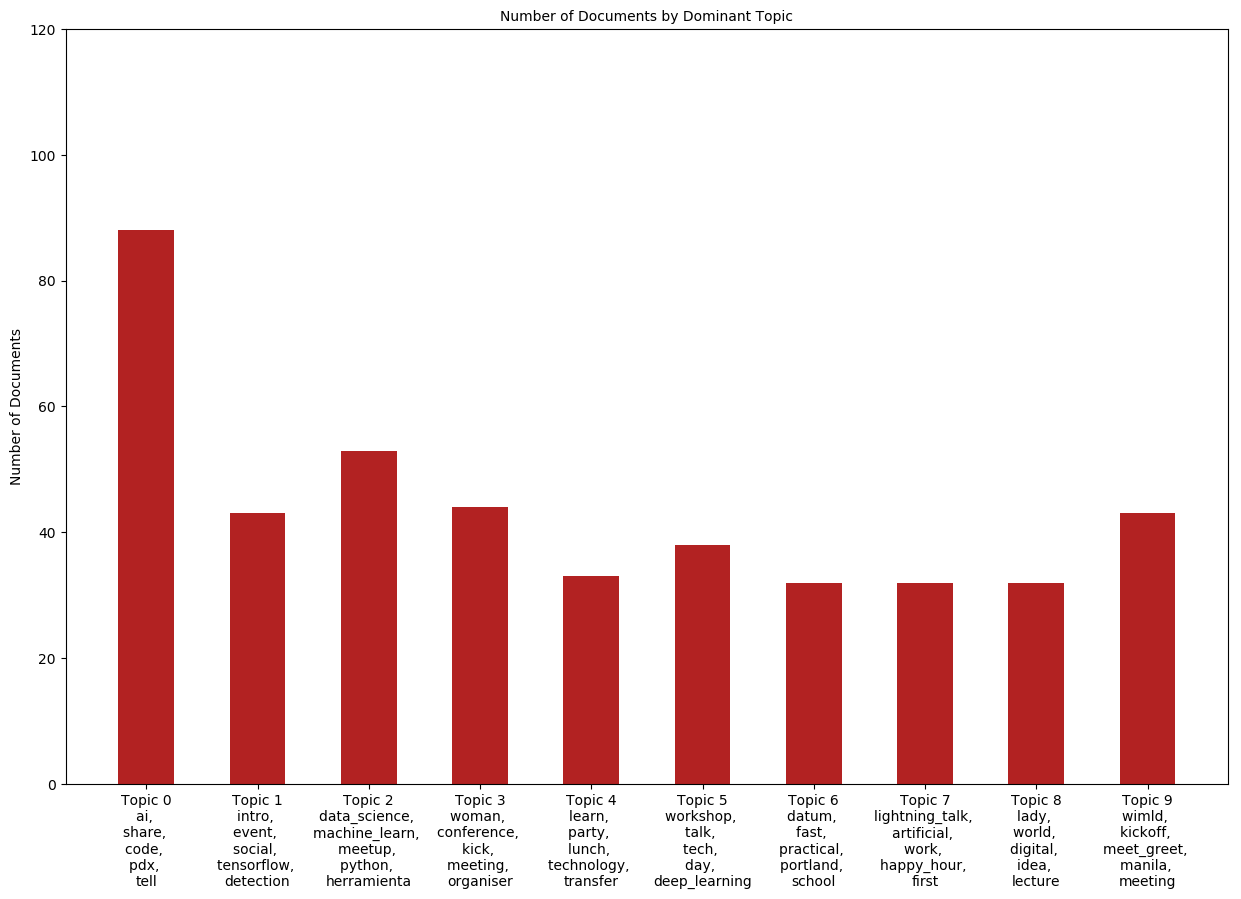

In [68]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, ax1 = plt.subplots(1, 1, figsize=(15, 10), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 120)

plt.show()

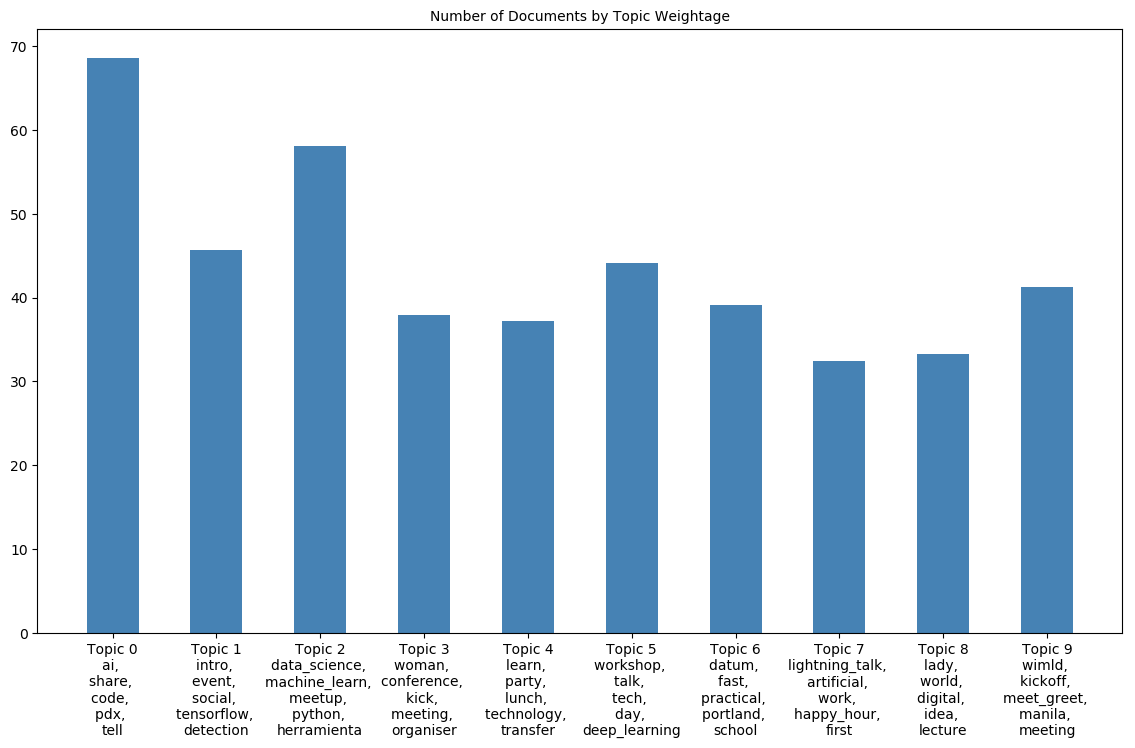

In [70]:
# Plot
fig, ax2 = plt.subplots(1, 1, figsize=(14, 8), dpi=100, sharey=True)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

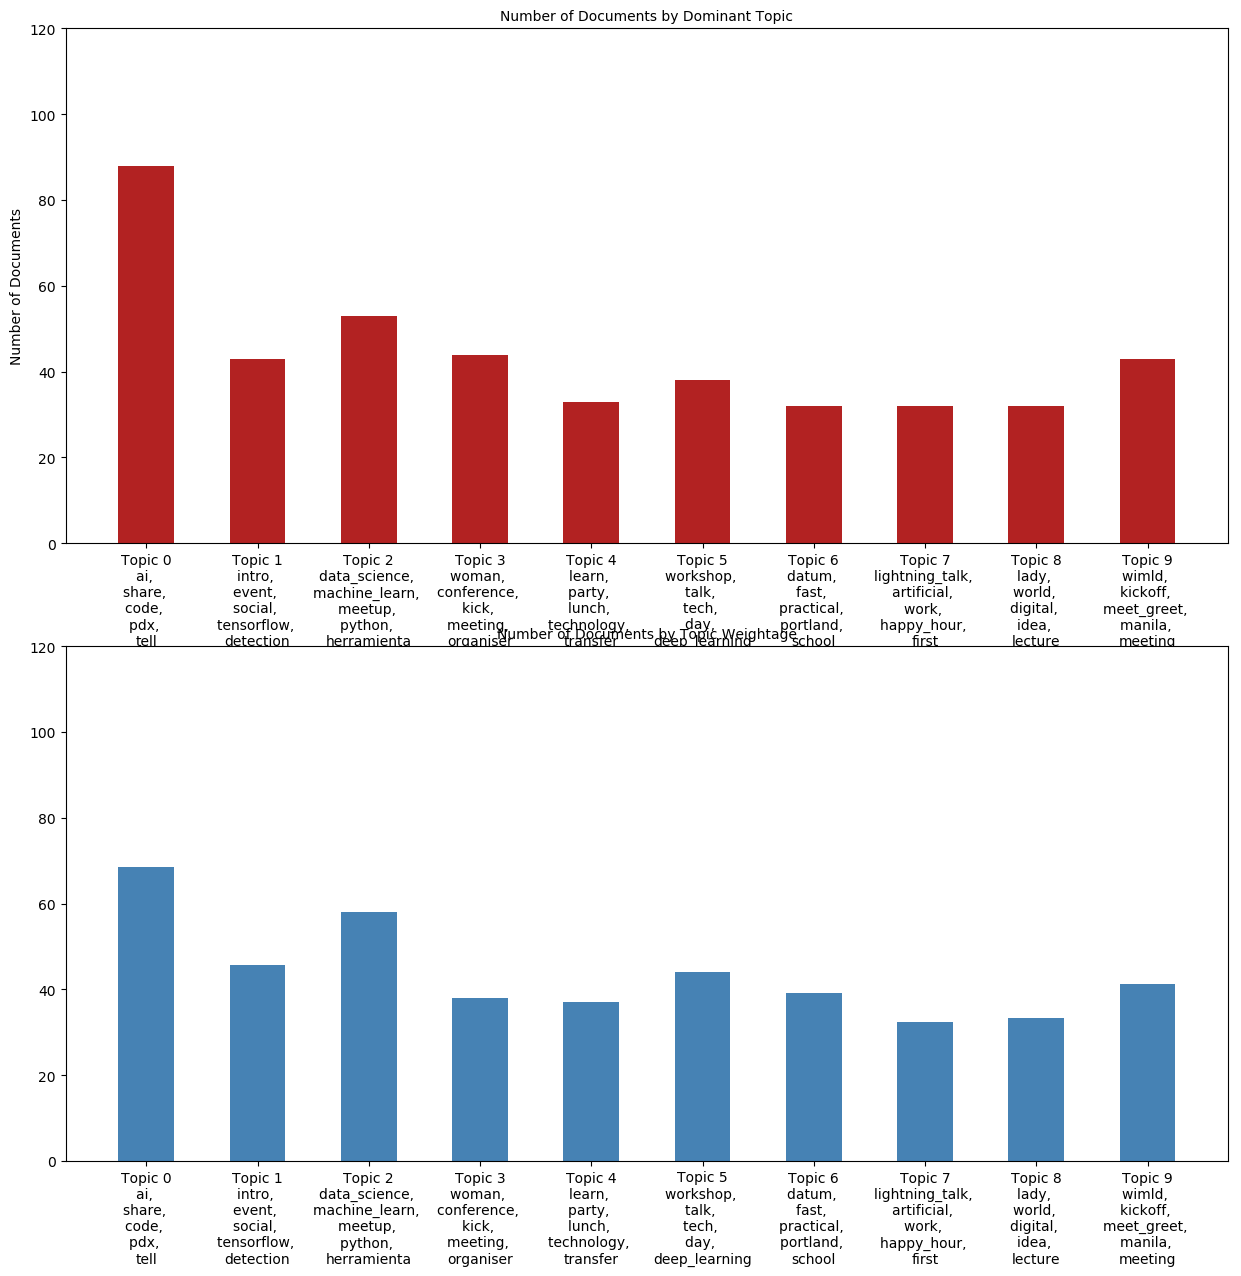

In [63]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 120)


# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## 13. t-SNE Clustering Chart
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [71]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 426 samples in 0.000s...
[t-SNE] Computed neighbors for 426 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 426 / 426
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.470528
[t-SNE] Error after 1000 iterations: 0.112996


Loading BokehJS ...

## 14. pyLDAVis
Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel().

In [74]:
#?pyLDAvis.gensim.prepare

In [75]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/reshamashaikh/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.318009  0.066912       1        1  12.219202
0     -0.008586 -0.173525       2        1  11.454181
5     -0.098965  0.242810       3        1  11.393762
1     -0.051129  0.047407       4        1  11.389482
6     -0.012780 -0.049086       5        1  10.377234
4     -0.044737 -0.016934       6        1   9.566592
9     -0.032693 -0.003891       7        1   9.315214
8     -0.040498 -0.027653       8        1   8.543763
3     -0.021644 -0.030885       9        1   8.014221
7     -0.006975 -0.055155      10        1   7.726349, topic_info=     Category       Freq           Term      Total  loglift  logprob
term                                                                
20    Default  39.000000   data_science  39.000000  30.0000  30.0000
146   Default  26.000000          woman  26.000000  29.0000  29.0000
87    Default  25.000000             ai  25.000000  28.0000  28.0000
5     Default  26.000000  machine_learn  26.000000  27.0000  27.0000
22    Default  20.000000          datum  20.000000  26.0000  26.0000
107   Default  14.000000          wimld  14.000000  25.0000  25.0000
293   Default  15.000000          share  15.000000  24.0000  24.0000
95    Default  15.000000         meetup  15.000000  23.0000  23.0000
96    Default  15.000000         python  15.000000  22.0000  22.0000
114   Default  13.000000       workshop  13.000000  21.0000  21.0000
367   Default  12.000000          intro  12.000000  20.0000  20.0000
220   Default  11.000000        kickoff  11.000000  19.0000  19.0000
228   Default  10.000000           lady  10.000000  18.0000  18.0000
31    Default  11.000000          event  11.000000  17.0000  17.0000
65    Default  10.000000           code  10.000000  16.0000  16.0000
313   Default  10.000000           talk  10.000000  15.0000  15.0000
359   Default   9.000000           tech   9.000000  14.0000  14.0000
203   Default   9.000000            day   9.000000  13.0000  13.0000
277   Default   9.000000         social   9.000000  12.0000  12.0000
144   Default   7.000000     conference   7.000000  11.0000  11.0000
218   Default   7.000000           fast   7.000000  10.0000  10.0000
410   Default   7.000000          learn   7.000000   9.0000   9.0000
59    Default   7.000000          world   7.000000   8.0000   8.0000
520   Default   7.000000      practical   7.000000   7.0000   7.0000
108   Default   7.000000  deep_learning   7.000000   6.0000   6.0000
752   Default   8.000000        meeting   8.000000   5.0000   5.0000
55    Default   6.000000          party   6.000000   4.0000   4.0000
538   Default   6.000000        digital   6.000000   3.0000   3.0000
745   Default   7.000000            pdx   7.000000   2.0000   2.0000
746   Default   7.000000           tell   7.000000   1.0000   1.0000
...       ...        ...            ...        ...      ...      ...
741   Topic10   2.502199        carrera   3.248988   2.2994  -3.9143
742   Topic10   2.502199       haciendo   3.248988   2.2994  -3.9143
198   Topic10   1.761977         design   2.321773   2.2846  -4.2651
204   Topic10   1.761976           life   2.321773   2.2846  -4.2651
168   Topic10   1.759845         create   2.319643   2.2843  -4.2663
120   Topic10   1.756415      wednesday   2.316213   2.2839  -4.2682
680   Topic10   1.746320     creativity   2.306133   2.2825  -4.2740
681   Topic10   1.746320      evolution   2.306133   2.2825  -4.2740
682   Topic10   1.746320           lisa   2.306133   2.2825  -4.2740
683   Topic10   1.746320           soro   2.306133   2.2825  -4.2740
661   Topic10   1.746315       imposter   2.306134   2.2825  -4.2740
662   Topic10   1.746315        morning   2.306134   2.2825  -4.2740
660   Topic10   1.746315        conquer   2.306134   2.2825  -4.2740
664   Topic10   1.746315       syndrome   2.306134   2.2825  -4.2740
663   Topic10   1.746315         sunday   2.306134   2.2825  -4.27

## 15. Conclusion
We started from scratch by importing, cleaning and processing the newsgroups dataset to build the LDA model. Then we saw multiple ways to visualize the outputs of topic models including the word clouds and sentence coloring, which intuitively tells you what topic is dominant in each topic. A t-SNE clustering and the pyLDAVis are provide more details into the clustering of the topics.

Where next? If you are familiar with [scikit learn](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/), you can build and grid search topic models using scikit learn as well.